<center><h1> Cleaning Process for Datasets</h1></center>

<left><h2>Dataset: MRI and Alzheimer's</h2></left>
<left><p>Source: <a href ="https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers"> Kaggle Dataset from OASIS site </a></p></left>
<left><p>Source 2: <a href ="https://sites.wustl.edu/oasisbrains/"> OASIS site and Fact Sheet</a></p></left>
<left><p>Additional Readings:
<li><a href="https://dash.harvard.edu/server/api/core/bitstreams/7312037c-5b39-6bd4-e053-0100007fdf3b/content">Open Access Series of Imaging Studies (OASIS): Study from Journal of Cognitive Neuroscience</a></p></left>
<li> <a href="https://cgatoolkit.ca/Uploads/ContentDocuments/MMSE.pdf">Mini Mental State Examination (MMSE)</a>
<li> <a href="https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://stacks.cdc.gov/view/cdc/75315/cdc_75315_DS1.pdf&ved=2ahUKEwjt4s6si66QAxWzKFkFHeIRLY4QFnoECD0QAQ&usg=AOvVaw2iaHQBbQA2LPdNGNcqT4l2"> SES Hollingshead index (PDF)</a>


<h3>Initial DB Connection:</h3>
<p>This is the target for transfering the cleaned dataset into</p>

In [46]:
# Dependencies:
# pip install python-dotenv
# pip install psycopg2

import os
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import find_dotenv, load_dotenv


load_dotenv(find_dotenv(usecwd=True))

HOST = os.getenv("HOST")
PORT = os.getenv("PORT",5432)
DBNAME = os.getenv("DBNAME")
USER = os.getenv("USER")
PASSWORD = os.getenv("PASSWORD")
   
conn = psycopg2.connect(f"host={HOST} port={PORT} dbname={DBNAME} user={USER} password={PASSWORD} gssencmode=disable") 

try:
    conn.autocommit = True #
    cur = conn.cursor()
    cur.execute("""select
    t.table_name AS table_name,
    column_name,
    data_type
    from information_schema.tables t
    INNER JOIN information_schema.columns c on c.table_schema = c.table_schema AND t.table_name = c.table_name
    WHERE c.table_schema= 'mnemos'""") 
    df_db = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    print(df_db)

except Exception as e:
    print(e)

finally:
    cur.close()

               table_name     column_name data_type
0   cross_sectional_oasis             asf   numeric
1   cross_sectional_oasis            nwbv   numeric
2   cross_sectional_oasis             sex   boolean
3   cross_sectional_oasis  education_type   integer
4   cross_sectional_oasis             cdr   numeric
5   cross_sectional_oasis             ses   integer
6   cross_sectional_oasis             age   integer
7   cross_sectional_oasis              id      text
8   cross_sectional_oasis   dominant_hand   boolean
9   cross_sectional_oasis            etiv   integer
10  cross_sectional_oasis            mmse   integer


<h3>Initial Dataset Import and Investigation:</h3>

<p>Pandas can usually detect the datatypes in the dataframe, but some may need further investigation.</p>

<b>cross_sectional_oasis features:</b>
<ul>
<li>ID text
<li>Sex boolean             (F = 1, M = 0)
<li>Dominant_hand boolean  (Right=1, Left = 0)
<li>Age integer
<li>Education_type integer (1: less than high school grad, 2: highschool grad, 3: some college, 4: college grad, 5: beyond college)
<li>*SES integer (socioeconomic status) (1: highest SES status, 5: lowest SES status)
<li>MMSE integer (Mini-Mental State Examination)
<li>CDR float (Clinial Dementia Rating) (0: nondemented, 0.5: very mild dementia, 1: mild dementia, 2: moderate dementia)
<li>ETIV integer integer (Estimated total intracranial volume mm cubed)
<li>NWBV integer float (Normalized whole brain volume)
<li>ASF float (Atlas scaling factor)
<li>Delay integer(measured in days, the delay between visits. Will likely be omitted)
</li>
    
*SES is assumed to be using the Hollingshead index as the research papers I found regarding this OASIS dataset referred to it as such and I can find no other sources that contradict this.

In [47]:
df = pd.read_csv("datasets\oasis_crosssectional.csv", header=None)

indexList = ['ID', 'Sex', 'Dominant_Hand', 'Age', 'Education', 'SES', 'MMSE_Score', 'CDR', 'Estimated_Intracranial_Vol', 'Normalized_Brain_Vol','ASF' ,'Delay']
df.columns = indexList

df.head()

,ID,Sex,Dominant_Hand,Age,Education,SES,MMSE_Score,CDR,Estimated_Intracranial_Vol,Normalized_Brain_Vol,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [48]:
na_list = list(df.columns[df.isna().any()])
print("Columns that need further investigation due to NaN values detection:", na_list ,"\n")

print(df.dtypes,"DETECTED CSV DATATYPES","\n")
print(f"Unique values for Sex: {df['Sex'].unique()}")
print(f"Unique values for Dominant_Hand: {df['Dominant_Hand'].unique()}")
print(f"Unique values for Age: {df['Age'].unique()}")
print(f"Unique values for Education_Years: {df['Education'].unique()}")
print(f"Unique values for SES: {df['SES'].unique()}")
print(f"Unique values for CDR: {df['CDR'].unique()}")
print(f"Unique values for MMSE: {df['MMSE_Score'].unique()}")
print(f"Unique values for eITBV: {df['Estimated_Intracranial_Vol'].unique()}")
print(f"Unique values for Norm_eitbv: {df['Normalized_Brain_Vol'].unique()}")
print(f"Unique values for ASF: {df['ASF'].unique()}")
print(f"Unique values for Delay: {df['Delay'].unique()}")

Columns that need further investigation due to NaN values detection: ['Education', 'SES', 'MMSE_Score', 'CDR', 'Delay'] 

ID                             object
Sex                            object
Dominant_Hand                  object
Age                             int64
Education                     float64
SES                           float64
MMSE_Score                    float64
CDR                           float64
Estimated_Intracranial_Vol      int64
Normalized_Brain_Vol          float64
ASF                           float64
Delay                         float64
dtype: object DETECTED CSV DATATYPES 

Unique values for Sex: ['F' 'M']
Unique values for Dominant_Hand: ['R']
Unique values for Age: [74 55 73 28 18 24 21 20 52 30 81 19 76 82 39 89 48 80 69 58 43 86 65 88
 51 84 27 23 70 38 62 47 29 64 57 78 83 72 46 79 77 90 66 71 67 33 63 49
 60 25 75 40 22 61 26 68 87 34 41 50 35 54 44 31 85 94 37 93 96 45 91 59
 92]
Unique values for Education_Years: [ 2.  4. nan  5.  3.  1.]
Uni

<h3>Cleaning Process:</h3>

<p>After investigation, <b>5 columns appear to need immediate evaluation; Education, SES, MMSE_Score, CDR, and Delay.</b> All have NAN values that need to be handled. If a row has majority of the specified columns NaN, it will be dropped due to lack of information gain.</p>

<ul>
<li> <b>CDR</b>: This is being used as our model's label, if the label is undeterministic then it will be discarded becasue it can't be used to train or test the model.
<li><b>SES</b>: Nans in SES column will be normalized according to the median value in order to keep the dataset shape consistent to the original</li>
<li><b>Delay</b>: It appears that Delay is that that useful for my group's model training as this provides little information on context. We assume it to be in relation to visits between the scans and other visits to take measurements.



Columns that need further investigation after CDR cleaning: ['SES'] 

SES MEAN: 2.490740740740741  SES MEDIAN: 2.0


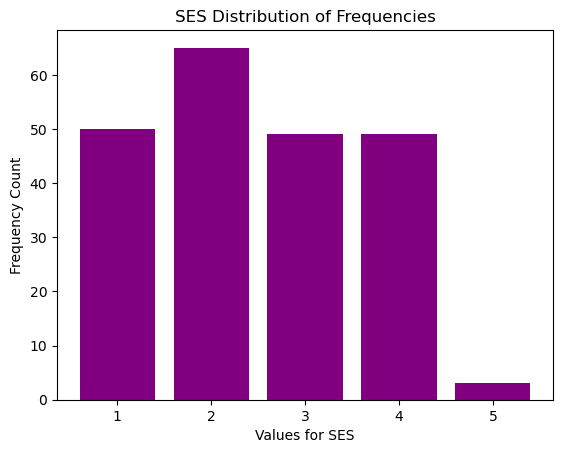

In [49]:
#CDR rating handling for NANs
df.dropna(how='any', subset=['CDR'], inplace=True)
df.drop('Delay', axis=1, inplace=True)
na_list = list(df.columns[df.isna().any()])
print("Columns that need further investigation after CDR cleaning:", na_list ,"\n")

ses_mean, ses_med = df['SES'].mean(), df['SES'].median()
ses_freq = df['SES'].value_counts()

print("SES MEAN:",ses_mean, " SES MEDIAN:",ses_med)

plt.bar(ses_freq.index,
        ses_freq.values,
       color='purple')
plt.xlabel('Values for SES')
plt.ylabel('Frequency Count')
plt.title('SES Distribution of Frequencies')
plt.show()

df['SES'] = df['SES'].fillna(2.0)

<h3>Conversion Process:</h3>
Now that all the NaN values are taken care of, the datatype conversions can be completed.
<ul>
<li> <b>Sex</b>: F will be encoded as 1, M will be encoded as 0
<li> <b>Dominant_Hand</b>: Left will be encoded as 1, R will be encoded as 0
<li> <b></b>: Float must be cast to an integer for importing

</ul>

In [63]:
df = df.replace({'Sex' : {'F':1, 'M':0}, 'Dominant_Hand' : {'L': 1, 'R': 0}})
df = df.convert_dtypes()

df.head()

,ID,Sex,Dominant_Hand,Age,Education,SES,MMSE_Score,CDR,Estimated_Intracranial_Vol,Normalized_Brain_Vol,ASF
0,OAS1_0001_MR1,0,0,74,2,3,29,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,0,0,55,4,1,29,0.0,1147,0.81,1.531
2,OAS1_0003_MR1,0,0,73,4,3,27,0.5,1454,0.708,1.207
8,OAS1_0010_MR1,0,0,74,5,2,30,0.0,1636,0.689,1.073
9,OAS1_0011_MR1,0,0,52,3,2,30,0.0,1321,0.827,1.329


In [64]:
df.to_csv('datasets\clean_oasis.csv', index=False,  header=False)

try:
    conn.autocommit = True
    cur = conn.cursor()
    f = open('datasets\clean_oasis.csv','r')
    cur.copy_from(f, 'cross_sectional_oasis', sep=',')
except Exception as e:
    print(e)

finally:
    f.close()